## LSTM prediction

Import modules and helper functions

In [1]:
import os
import sys

USE_GPU = False
if (USE_GPU):
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    from keras.layers import CuDNNLSTM as LSTM
else:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt

from data_loader import load_data

def newModel(input_shape):
    model = Sequential()
    model.add(LSTM(20, input_shape=(x_train.shape[1:]),
        return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear')) # the data is not normalized, the 'linear' activation fits the case
    model.compile(loss='mae', optimizer='adam')
    return model

def train(x_train, y_train, lim_epochs=100):
    bs = 12*8 # Use the batch-size based on used hardware
    # We will use early stopping to prevent overfitting
    history = model.fit(
        x_train, y_train,
        batch_size=bs,
        epochs=lim_epochs,
        validation_split=0.1,
        shuffle=True,
        callbacks=[EarlyStopping(monitor='val_loss', patience=20)],
        verbose=1
        )
    
    def show_history():
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Losses')
        plt.ylabel('Mean absolute error')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='best')
        plt.show()
        
    show_history()
    
def evaluateModel(x_test, y_true):
    """Shows a graph with real and predicted data
    Arguments: 
        x_test - numpy array, shape is related to the model used
        y_true - a numpy array or a list of the values to compare 
    """
    y_pred = model.predict(x_test)[:,0] 
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.title("True and predicted data")
    plt.xlabel("Hour")
    plt.ylabel("cnt")
    plt.legend()
    plt.show()
    print("Mean absolute error", mae(y_true, y_pred)) # np.mean(np.abs(y_pred - y_test))
    print("RMSE", np.sqrt(np.mean((y_pred-y_true)**2)))

def saveModel(model_name):
    """Save the current model to file.
            model_name: filename without extensions"""
    model_json = model.to_json()
    json_file = open(model_name + ".json", "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights(model_name + ".h5")
    print('"' + model_name + '" was saved.')

def loadModel(model_name):
    """Load an existing model.
        model_name: filename without extensions"""
    json_file = open(model_name + ".json", "r")
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(model_name + ".h5")
    model.compile(loss='mae', optimizer='adam')
    print('"' + model_name + '" was loaded.')
    return model

def getPrediction(data):
    """Predict the next value
        data"""
    data = np.expand_dims(data, axis=0)
    return model.predict(data)[:,0][0]

Using TensorFlow backend.


In [2]:
#Load the data
x_train, y_train, x_test, y_test = load_data()

In [ ]:
model = Sequential()
model=newModel(x_train)
train(x_train, y_train, 500)

In [ ]:
saveModel("LSTM_test")

In [3]:
model=loadModel("LSTM_test")

"LSTM_test" was loaded.


### Model evaluation
evaluateModel uses the data passed in arguments to show the difference between true and predicted data.

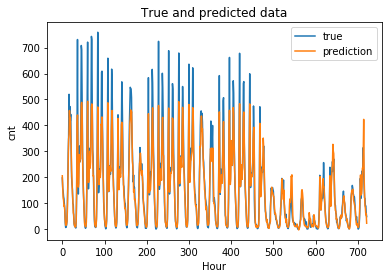

Mean absolute error 28.0800257442
RMSE 50.7794206698


In [4]:
# x_test, y_test - data for one month
evaluateModel(x_test, y_test)

### Use in production
To use the code in production, an external program sends a matrix to the _getPrediction_ method. The code can be called using COM under windows or processing http requests. 

The input of the method based on the trained model and must be (72, 15), where 72 is for the number of previous measurements and 15 is for the number of parameters. 

Example:

In [5]:
current_measurements = x_test[42,:,:] # simulated current data. Shape is (72, 15)

getPrediction(current_measurements)

287.22437

### Conclusions

The models shows good prediction results, allowing us to predict the amount of rented bikes next hour.

To improve the result, we can:

- Convert categorical variables into dummy/indicator variables
- Make the data stationary
- Use another window sizes 
- Normalize the data
- Detect and handle outliers
- Change the ANN parameters, optimizer and architecture
- Use more data for training